In [1]:
import matplotlib.pyplot as plt
import numpy as np
import polars as pl
from scipy.optimize import curve_fit
import os

# 連続NDフィルタ

NDL-10C-2

https://www.thorlabs.co.jp/newgrouppage9.cfm?objectgroup_id=1623&pn=NDL-10C-2

$$
    T:透過率 \quad OD:光学濃度 \\
    OD = \log_{10} (\frac{1}{T}) \quad or \quad T = 10^{-OD}
$$


In [2]:
def optical_density(length):
    """
    length: mm
    """
    if length <= 5:
        return 0
    elif length <= 50:
        return (length-5) * 2 / 45
    else:
        return 2

In [3]:
def transmisson(od):
    """
    od: optical density
    """
    return 10 ** (-od)

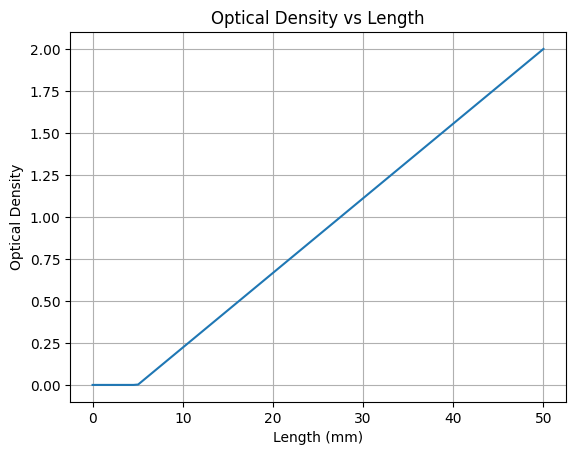

In [4]:
xlist = np.linspace(0, 50, 100)
ylist = [optical_density(x) for x in xlist]
plt.plot(xlist, ylist)
plt.xlabel("Length (mm)")
plt.ylabel("Optical Density")
plt.title("Optical Density vs Length")
plt.grid()
plt.show()

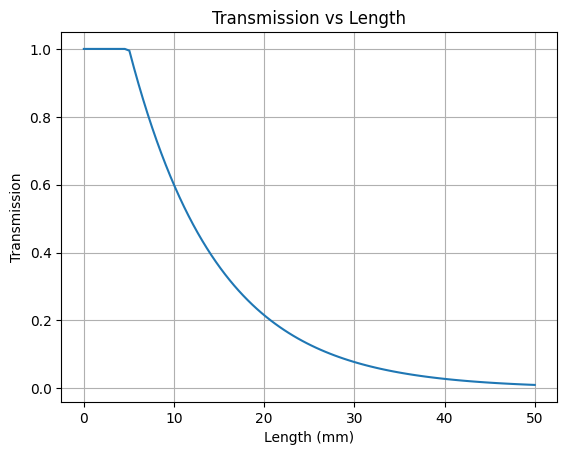

In [5]:
xlist = np.linspace(0, 50, 100)
ylist = [transmisson(optical_density(x)) for x in xlist]
plt.plot(xlist, ylist)
plt.xlabel("Length (mm)")
plt.ylabel("Transmission")
plt.title("Transmission vs Length")
plt.grid()
plt.show()

# Ti-Sapレーザーのフィッティング
Ti-Sapレーザーのレンジとハンディパワーメーターのレンジのうち785nmしか共通していないので、785nmのデータを使ってフィッティングを行う。

In [6]:
newtisp785filename = "../data/powerdata/785_new_20250116.csv"

In [7]:
newtisp785data =  pl.read_csv(newtisp785filename, has_header=True)

In [8]:
def plotdata(df, length):
    fig = plt.figure()
    ax1 = fig.add_subplot(111)

    ax1.plot(df["step"], df[f"handy-end"] * 1000, label="handy-end", color="red")

    
    ax1.plot(df["step"], df[f"set"] * 1000, label="set", color="green")
    ax1.set_ylim(0, 3.0)

    ax2 = ax1.twinx()
    ax2.plot(df["step"], df["ratio"], label="ratio_s2h", color="black")

    ax2.set_ylim(0, 6.0)

    h1, l1 = ax1.get_legend_handles_labels()
    h2, l2 = ax2.get_legend_handles_labels()
    ax1.legend(h1+h2, l1+l2, loc='upper right')

    ax1.set_ylabel("power[mW]")
    ax2.set_ylabel("Ratio")
    ax1.set_xlabel("Step")

    plt.title(f"Length: {length} mm")

    plt.show()

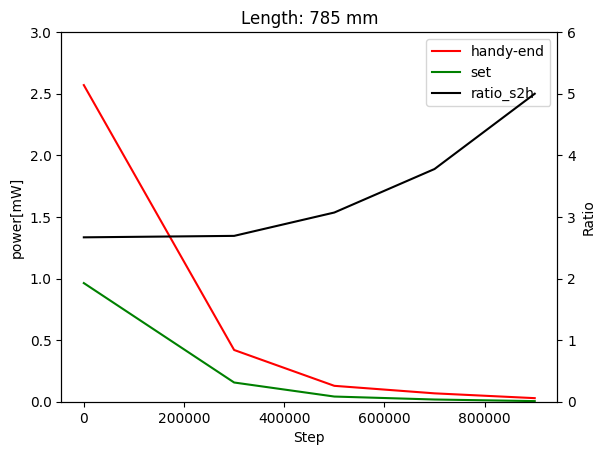

In [9]:
plotdata(newtisp785data, 785)

NDフィルターの位置や依存ではなくレーザーパワー依存な気がする

# NDフィルター位置とパワー比率（パワーメータ設置部とサンプル部）の関係

In [10]:
def ratio(x, a, b, c):
        return (c * x - a * c) * (x > a) + b

# above function is same as below
# def ratio(x, a, b, c):
#     if x < = a:
#         return b
#     else:
#         return c * x - a * c + b

In [11]:
popt, pcov = curve_fit(ratio, newtisp785data["step"], newtisp785data["ratio"])
print(popt)

[4.36756476e+05 2.68052560e+00 4.82142858e-06]


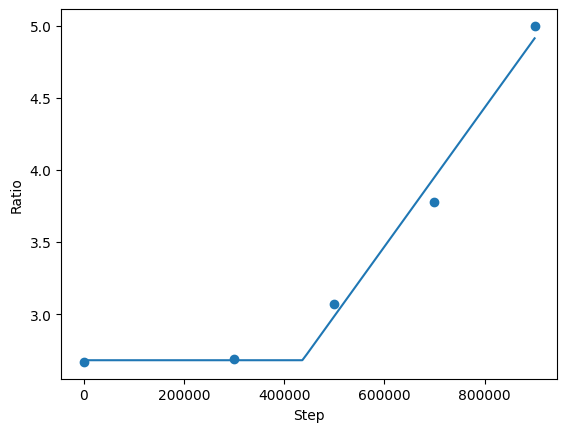

In [12]:
plt.scatter(newtisp785data["step"], newtisp785data["ratio"])
xlist = np.linspace(0, max(newtisp785data["step"]), 100)
plt.plot(xlist, [ratio(x, *popt) for x in xlist])
plt.xlabel("Step")
plt.ylabel("Ratio")
plt.show()

In [13]:
def update_ratio(x, a, b):
    return a * x ** 2 + b

In [14]:
popt_u, pcov = curve_fit(update_ratio, newtisp785data["step"], newtisp785data["ratio"])
print(popt_u)

[2.95260088e-12 2.47359842e+00]


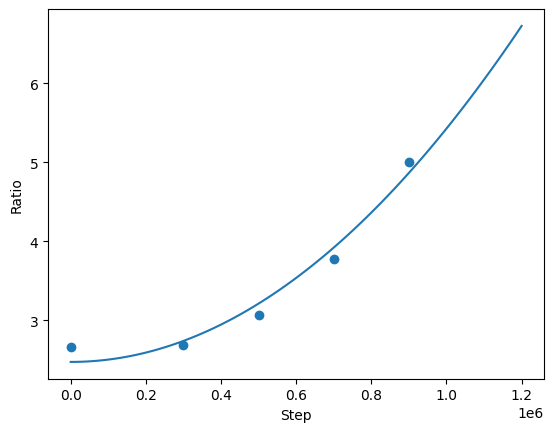

In [15]:
plt.scatter(newtisp785data["step"], newtisp785data["ratio"])
xlist = np.linspace(0, 1200000, 100)
plt.plot(xlist, [update_ratio(x, *popt_u) for x in xlist])
plt.xlabel("Step")
plt.ylabel("Ratio")
plt.show()

# PIDゲイン調整用のシミュレータ

In [16]:
def nd(input_power, ndstep):
    return input_power * transmisson(optical_density(ndstep/34555))

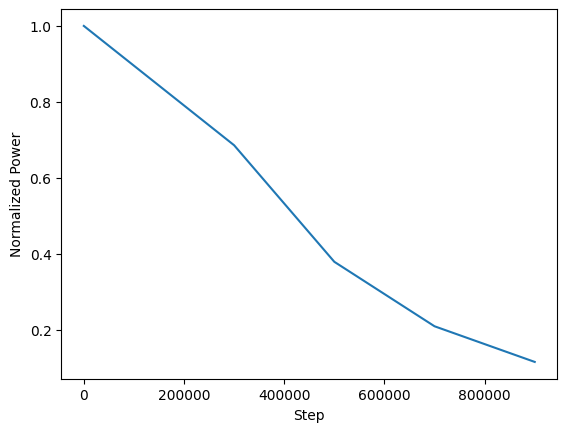

In [17]:
plt.plot(newtisp785data["step"], [nd(1.0, x) for x in newtisp785data["step"]])
plt.xlabel("Step")
plt.ylabel("Normalized Power")
plt.show()

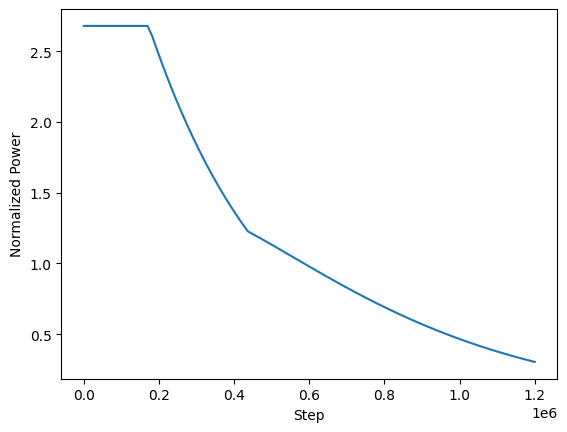

In [18]:
xlist = np.linspace(0, 1200000, 100)
plt.plot(xlist, [nd(1.0, x) * ratio(x, *popt)for x in xlist])
plt.xlabel("Step")
plt.ylabel("Normalized Power")
plt.show()

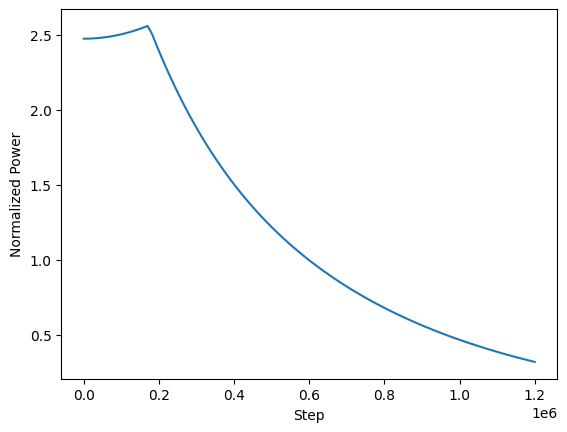

In [19]:
plt.plot(xlist, [nd(1.0, x) * update_ratio(x, *popt_u)for x in xlist])
plt.xlabel("Step")
plt.ylabel("Normalized Power")
plt.show()

In [20]:
class ndfilter_test():
    def __init__(self):
        self.ndstep = 0

    def move_to(self, ndstep):
        self.ndstep = ndstep
    
    def get_position(self):
        return self.ndstep

In [21]:
input_power = 10 * 10 ** -3
def pid_control_power(targetpower, NDfilter, NDinitpos=4.0e5, max_retry=100, eps=0.01):
    '''
    PID制御を用いて目標パワーに制御する関数
    args:
        targetpower(float): 目標パワー[W]
        wavelength(int): 現在の波長[nm]
        powermeter(juno): パワーメーターの自作ドライバークラス
        NDfilter(ThorlabStage): NDフィルターがついているthorlabステージの自作ドライバークラス
        eps(float): 目標パワーの許容誤差[W]
    return:
        None
    '''
    # パワーメータの値が安定するまで待機時間が必要なので，波長やパワーを変更した後には待機時間を設ける
    poslog =[]
    powerlog = []
    r = 5.0e7
    Kp = 1.2 * r
    Ki = 0.01 * r
    Kd = 0.01 * r
    dt = 1.0
    acc = 0.0
    diff = 0.0
    prev = 0.0
    if NDinitpos != NDinitpos:
        NDfilter.move_to(NDinitpos)
        poslog.append(NDinitpos)
    elif NDinitpos == NDinitpos and NDfilter.get_position() <NDinitpos:##ポジションが0に近いときは，透過率が高すぎてPID制御に時間がかかりすぎるので，透過率を下げる
        NDfilter.move_to(NDinitpos)
        poslog.append(NDinitpos)
    for i in range(max_retry):
        nowndstep = NDfilter.get_position()
        measuredpower = nd(input_power, nowndstep) * 0.2
        nowpower = measuredpower * ratio(nowndstep, *popt)
        if nowpower < targetpower - eps or targetpower + eps < nowpower:
            error = nowpower - targetpower
            acc += (error + prev) * dt /2
            diff = (error - prev) / dt

            tostep = nowndstep + Kp * error + Ki * acc + Kd * diff
            NDfilter.move_to(tostep)
            poslog.append(tostep)
            powerlog.append(nowpower)

            prev = error
        else:
            break
    return poslog, powerlog

In [22]:
NDfilter = ndfilter_test()
targetpower = 5.0 * 10 ** -3
poslog, powerlog = pid_control_power(targetpower, NDfilter, eps = targetpower * 0.05)

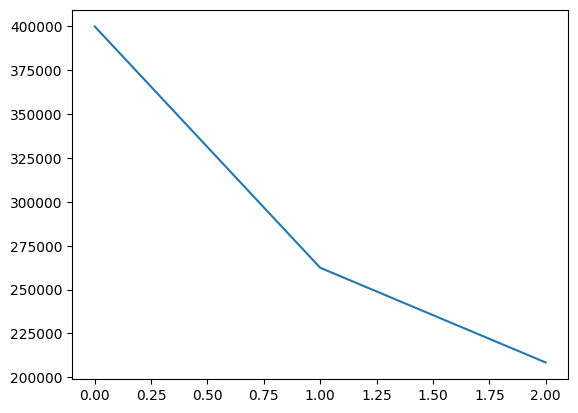

In [23]:
plt.plot(poslog)
plt.show()

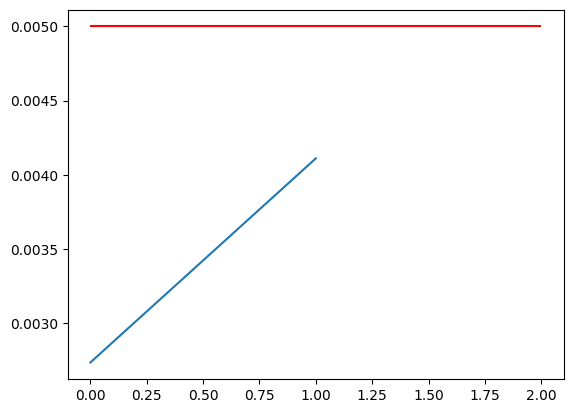

In [24]:
plt.plot(powerlog)
plt.hlines(targetpower, 0, len(powerlog), "red")
plt.show()